<a href="https://colab.research.google.com/github/sayak-1108/Multi-Scale-Forest-Fire-Prediction/blob/main/forest_fire_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import tensorflow as tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


<ipython-input-34-8bc4dc43b80c>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
#Mount google drive to google colab
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#import dataset from google drive
df = pd.read_csv("/content/gdrive/My Drive/Datasets/Forest Fire dataset/forestfires.csv")
df.head(10)  #Gives first ten rows of the dataset

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0
5,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.0
6,8,6,aug,mon,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0.0
7,8,6,aug,mon,91.5,145.4,608.2,10.7,8.0,86,2.2,0.0,0.0
8,8,6,sep,tue,91.0,129.5,692.6,7.0,13.1,63,5.4,0.0,0.0
9,7,5,sep,sat,92.5,88.0,698.6,7.1,22.8,40,4.0,0.0,0.0


### **Attribute Information:**

*  X : x-axis spatial coordinate within the Montesinho park map: 1 to 9
*  Y : y-axis spatial coordinate within the Montesinho park map: 2 to 9
*  month : month of the year: ‘jan’ to ‘dec’
*  day : day of the week: ‘mon’ to ‘sun’
*  FFMC : FFMC (Fine Fuel Moisture Code) index from the FWI system: 18.7 to 96.20
*  DMC : DMC (Duff Moisture Code) index from the FWI system: 1.1 to 291.3
*  DC : DC (Drought Code) index from the FWI system: 7.9 to 860.6
*  ISI : ISI (Initial Spread Index) index from the FWI system: 0.0 to 56.10
*  temp : temperature in Celsius degrees: 2.2 to 33.30
*  RH : relative humidity in %: 15.0 to 100
*  wind : wind speed in km/h: 0.40 to 9.40
*  rain : outside rain in mm/m2 : 0.0 to 6.4
*  area : the burned area of the forest (in ha): 0.00 to 1090.84


In [ ]:
df['size_category'] = np.where(df['area']>6, '1', '0')
df['size_category']= pd.to_numeric(df['size_category'])
df.tail(10)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
507,2,4,aug,fri,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.00,0
508,1,2,aug,fri,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.00,0
509,5,4,aug,fri,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,2.17,0
510,6,5,aug,fri,91.0,166.9,752.6,7.1,18.2,62,5.4,0.0,0.43,0
511,8,6,aug,sun,81.6,56.7,665.6,1.9,27.8,35,2.7,0.0,0.00,0
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,1
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,1
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,1
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0
516,6,3,nov,tue,79.5,3.0,106.7,1.1,11.8,31,4.5,0.0,0.00,0


For classification problem, we attempt to add a new column, namely *size_category* to categorize the data into two categories:

*  If the value of the area < 6 then the size_category will be labeled as 0 (Small Fire)
*  If the value of the area ≥ 6 then the size_category will be labeled as 1 (Wide Fire)



In [ ]:
df['size_category'].value_counts()

0    378
1    139
Name: size_category, dtype: int64

In [ ]:
# Percentage for PieChart
percentage = df.size_category.value_counts(normalize=True)*100
percentage

0    73.11412
1    26.88588
Name: size_category, dtype: float64

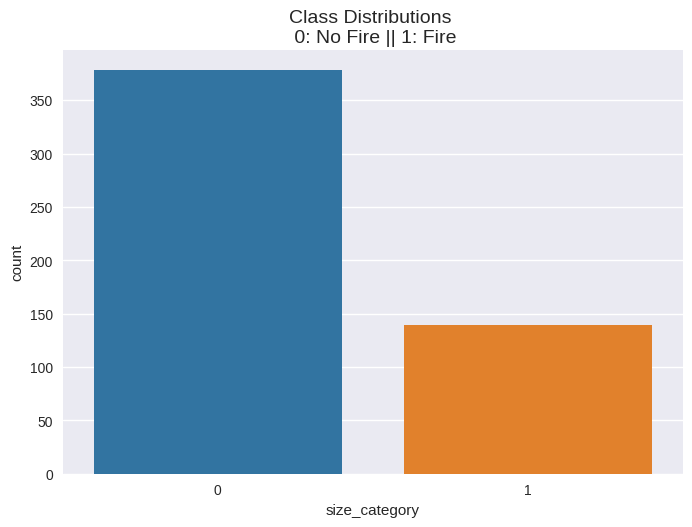

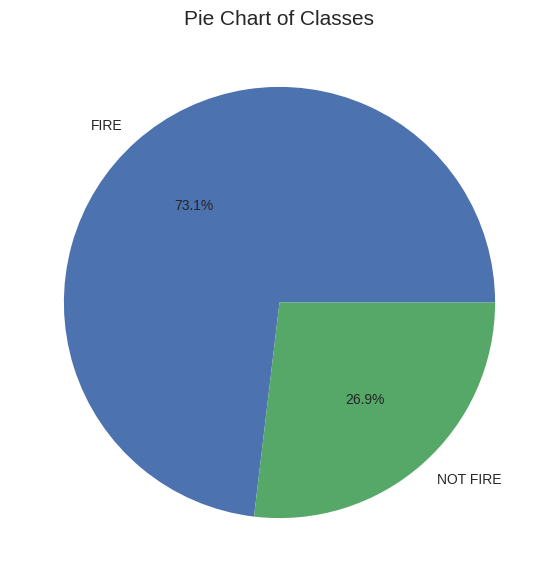

In [ ]:
sns.countplot(x='size_category', data=df, palette="tab10")
plt.title('Class Distributions \n 0: No Fire || 1: Fire', fontsize=14)
#plotting PieChart
classlabels = ["FIRE", "NOT FIRE"]
plt.figure(figsize =(12, 7))
plt.pie(percentage,labels = classlabels,autopct='%1.1f%%')
plt.title ("Pie Chart of Classes", fontsize = 15)
plt.show()

In [ ]:
df.columns.to_list()

['X',
 'Y',
 'month',
 'day',
 'FFMC',
 'DMC',
 'DC',
 'ISI',
 'temp',
 'RH',
 'wind',
 'rain',
 'area',
 'size_category']

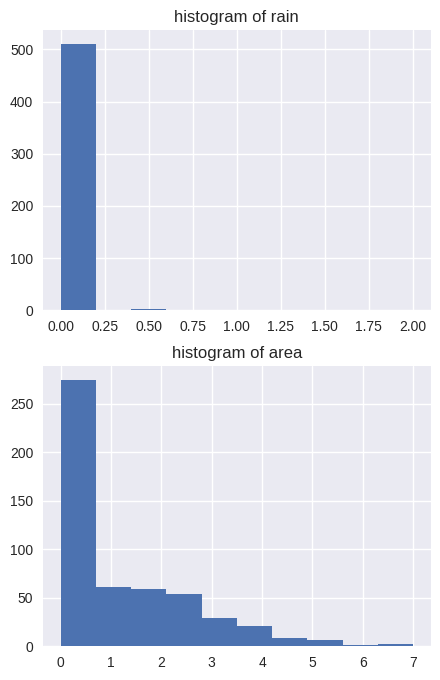

In [ ]:
# natural logarithm scaling (+1 to prevent errors at 0)
df.loc[:, ['rain', 'area']] = df.loc[:, ['rain', 'area']].apply(lambda x: np.log(x + 1), axis = 1)
# visualizing
fig, ax = plt.subplots(2, figsize = (5, 8))
ax[0].hist(df['rain'])
ax[0].title.set_text('histogram of rain')
ax[1].hist(df['area'])
ax[1].title.set_text('histogram of area')

In [ ]:
#converting categorical columns(strings) into numerical values (int)
label_encoder = LabelEncoder()
df['day'] = label_encoder.fit_transform(df['day'])
df['month'] = label_encoder.fit_transform(df['month'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   X              517 non-null    int64  
 1   Y              517 non-null    int64  
 2   month          517 non-null    int64  
 3   day            517 non-null    int64  
 4   FFMC           517 non-null    float64
 5   DMC            517 non-null    float64
 6   DC             517 non-null    float64
 7   ISI            517 non-null    float64
 8   temp           517 non-null    float64
 9   RH             517 non-null    int64  
 10  wind           517 non-null    float64
 11  rain           517 non-null    float64
 12  area           517 non-null    float64
 13  size_category  517 non-null    int64  
dtypes: float64(8), int64(6)
memory usage: 56.7 KB


In [ ]:
#count the number of missing (NaN) values in each column of the DataFrame
df.isna().sum()

X                0
Y                0
month            0
day              0
FFMC             0
DMC              0
DC               0
ISI              0
temp             0
RH               0
wind             0
rain             0
area             0
size_category    0
dtype: int64

In [ ]:
df.corr()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
X,1.000000,0.539548,-0.017303,-0.009129,-0.021039,-0.048384,-0.085916,0.006210,-0.051258,0.085223,0.018798,0.082695,0.061995,0.045248
Y,0.539548,1.000000,-0.062162,0.030100,-0.046308,0.007782,-0.101178,-0.024488,-0.024103,0.062221,-0.020341,0.041580,0.038838,0.015363
month,-0.017303,-0.062162,1.000000,-0.150982,-0.007636,-0.173152,0.219439,-0.172087,-0.073802,-0.102057,-0.141131,-0.098473,0.039974,0.032559
day,-0.009129,0.030100,-0.150982,1.000000,0.074914,0.070218,0.058737,0.117738,0.148672,-0.103389,-0.034504,0.054163,0.028812,0.003550
FFMC,-0.021039,-0.046308,-0.007636,0.074914,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.066614,0.046799,0.022063
DMC,-0.048384,0.007782,-0.173152,0.070218,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.094703,0.067153,0.034715
DC,-0.085916,-0.101178,0.219439,0.058737,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.044116,0.066360,0.019428
ISI,0.006210,-0.024488,-0.172087,0.117738,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.081561,-0.010347,-0.008726
temp,-0.051258,-0.024103,-0.073802,0.148672,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.066413,0.053487,0.006021
RH,0.085223,0.062221,-0.102057,-0.103389,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.143874,-0.053662,-0.045243


<Axes: >

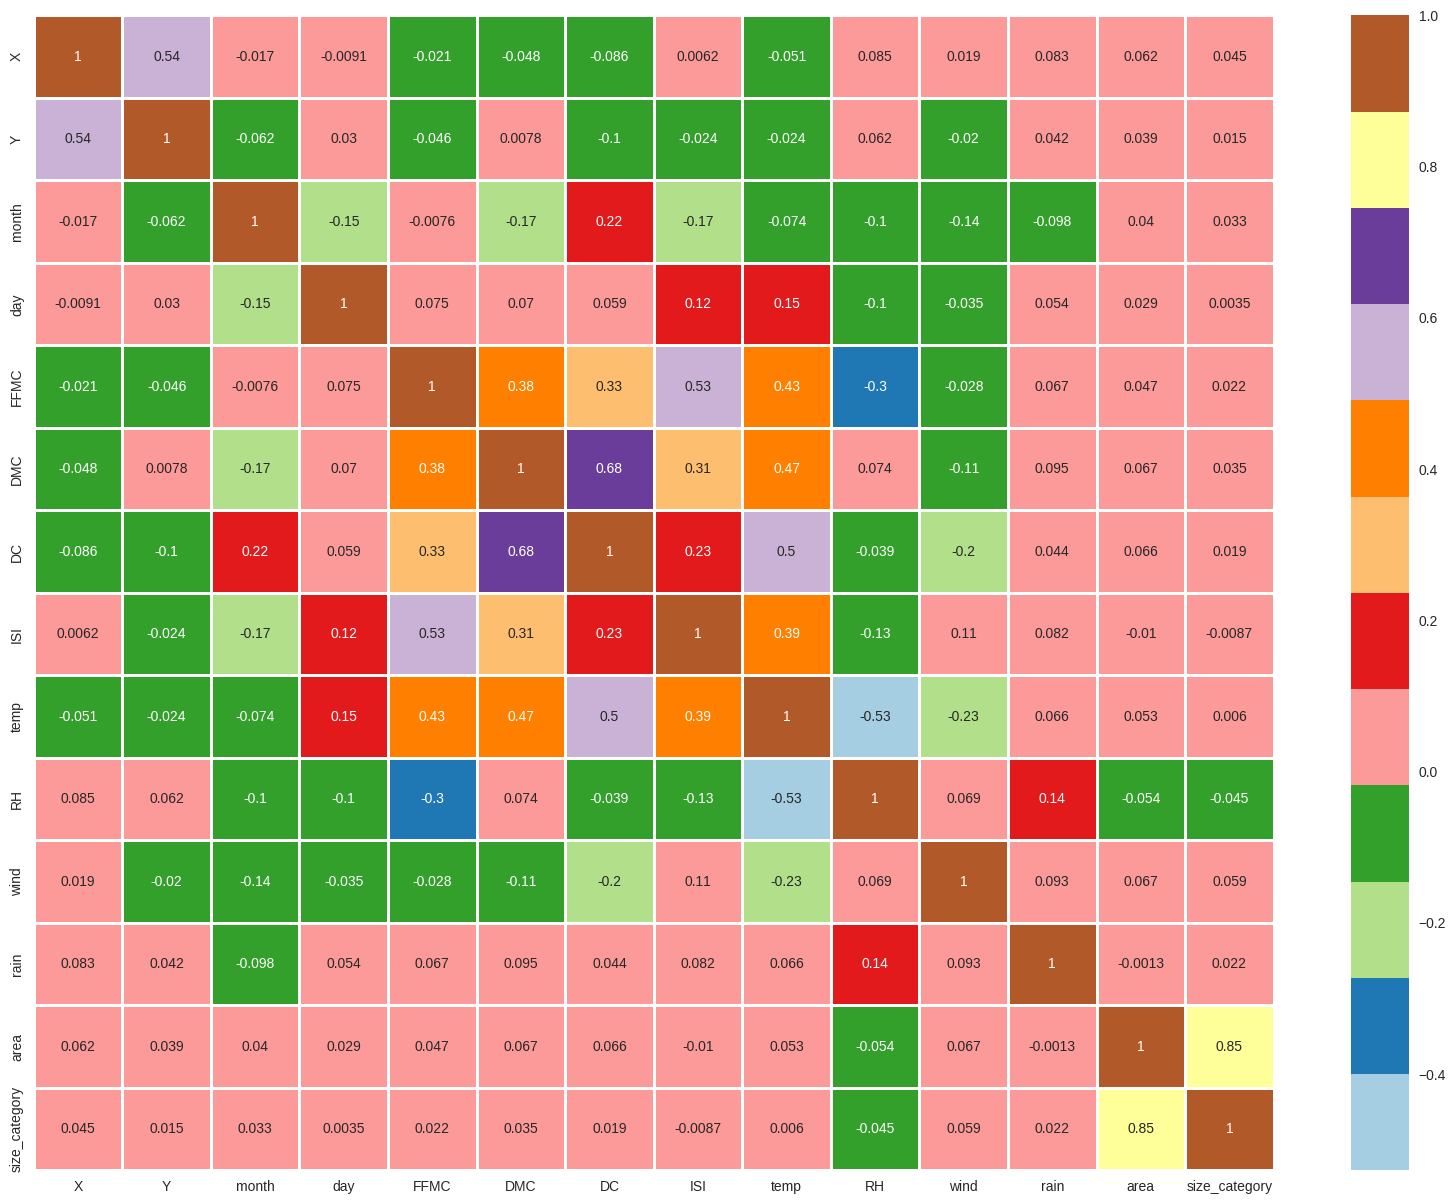

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(),annot= True,linewidths=1, linecolor="white", cbar=True,
            cmap = "Paired",xticklabels="auto", yticklabels="auto")

In [ ]:
features = df.drop(['size_category'], axis = 1)
labels = df['size_category'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size = 0.2, random_state = 42)
"""It randomly shuffles and splits the features and labels into X_train, X_test, y_train, and y_test.
The test_size parameter specifies the proportion of data to be allocated to the testing set, and random_state ensures reproducibility by setting a random seed.
Data is randomly splitted into training data (80 %) and testing data(20%)"""

'It randomly shuffles and splits the features and labels into X_train, X_test, y_train, and y_test.\nThe test_size parameter specifies the proportion of data to be allocated to the testing set, and random_state ensures reproducibility by setting a random seed.\nData is randomly splitted into training data (80 %) and testing data(20%)'

In [ ]:
# fitting scaler
sc_features = StandardScaler()
# transforming features
X_test = sc_features.fit_transform(X_test)
X_train = sc_features.transform(X_train)
# features
X_test = pd.DataFrame(X_test, columns = features.columns)
X_train = pd.DataFrame(X_train, columns = features.columns)
# labels
y_test = pd.DataFrame(y_test, columns = ['size_category'])
y_train = pd.DataFrame(y_train, columns = ['size_category'])
X_train.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,-0.293766,-0.927776,1.329914,-0.405726,0.342959,-0.060220,0.867158,-0.249015,0.784070,-1.071784,-0.054362,-0.137348,0.219260
1,-0.293766,-0.161993,1.329914,-0.908054,-0.057456,0.370353,0.600021,-0.465731,-0.203920,-0.279375,-1.042369,-0.137348,0.177491
2,-1.130796,0.603791,-0.963802,1.101257,0.312158,0.834731,0.483714,0.664288,0.221938,0.248898,-0.054362,-0.137348,0.180797
3,-0.712281,-0.161993,-0.963802,1.101257,1.544206,1.341810,0.537142,0.664288,2.283090,-1.071784,-1.042369,-0.137348,1.087255
4,0.124750,-0.161993,-0.505059,0.096601,-1.320305,-1.602809,-2.022846,-0.945602,-1.106740,0.645102,-1.042369,-0.137348,0.578923


By applying the StandardScaler, you transform your data so that it has a mean of 0 and a standard deviation of 1, which can be important for certain machine learning algorithms

# Base Model
create our ANN model by using a certain class of Keras named Sequential. Once we initialize our ANN, we are now going to create layers. Here we are going to create a base model network that will have :

*   1 input layer
*   2 hidden layers
*   1 dropout layer
*   1 output layer

model.add(Dense(6, input_dim=13, activation='relu')): This line adds the first hidden layer to the model. It has 6 units, expects input data with 13 features, and uses the ReLU activation function.

In [ ]:
model = Sequential()
model.add(Dense(6, input_dim=13, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(6, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'relu'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 6)                 84        
                                                                 
 dense_45 (Dense)            (None, 6)                 42        
                                                                 
 dense_46 (Dense)            (None, 6)                 42        
                                                                 
 dropout_11 (Dropout)        (None, 6)                 0         
                                                                 
 dense_47 (Dense)            (None, 1)                 7         
                                                                 
Total params: 175 (700.00 Byte)
Trainable params: 175 (700.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile Model
model.compile(optimizer = 'adam', metrics=['accuracy'], loss ='binary_crossentropy')
# Train Model
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 100)

Epoch 1/100
42/42 [==============================] - 2s 13ms/step - loss: 4.5375 - accuracy: 0.3559 - val_loss: 2.9514 - val_accuracy: 0.3173
Epoch 2/100
42/42 [==============================] - 0s 8ms/step - loss: 3.1458 - accuracy: 0.4165 - val_loss: 1.6682 - val_accuracy: 0.3750
Epoch 3/100
42/42 [==============================] - 0s 7ms/step - loss: 2.2711 - accuracy: 0.4576 - val_loss: 0.8938 - val_accuracy: 0.4615
Epoch 4/100
42/42 [==============================] - 0s 7ms/step - loss: 1.5701 - accuracy: 0.5085 - val_loss: 0.6875 - val_accuracy: 0.5577
Epoch 5/100
42/42 [==============================] - 0s 7ms/step - loss: 1.3802 - accuracy: 0.5569 - val_loss: 0.7164 - val_accuracy: 0.5481
Epoch 6/100
42/42 [==============================] - 0s 6ms/step - loss: 1.6107 - accuracy: 0.5375 - val_loss: 0.6976 - val_accuracy: 0.5481
Epoch 7/100
42/42 [==============================] - 0s 7ms/step - loss: 1.3948 - accuracy: 0.5860 - val_loss: 0.6806 - val_accuracy: 0.5481
Epoch 8/100


In [ ]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, valid_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Valid: %.3f' % (train_acc, valid_acc))

Train: 0.969, Valid: 0.923


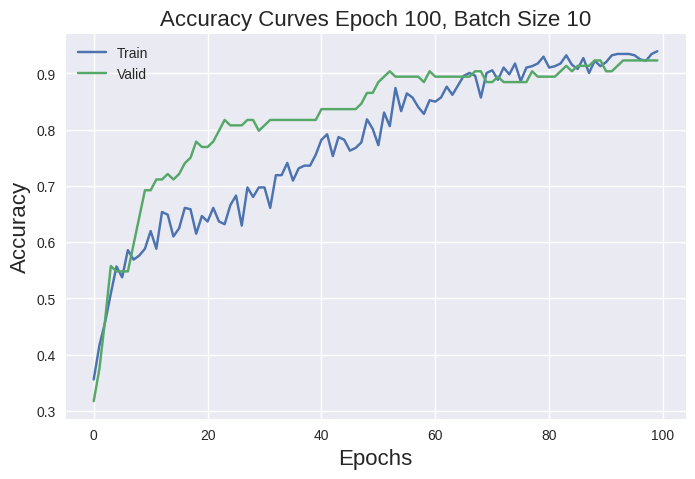

In [ ]:
plt.figure(figsize=[8,5])
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Valid')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves Epoch 100, Batch Size 10', fontsize=16)
plt.show()

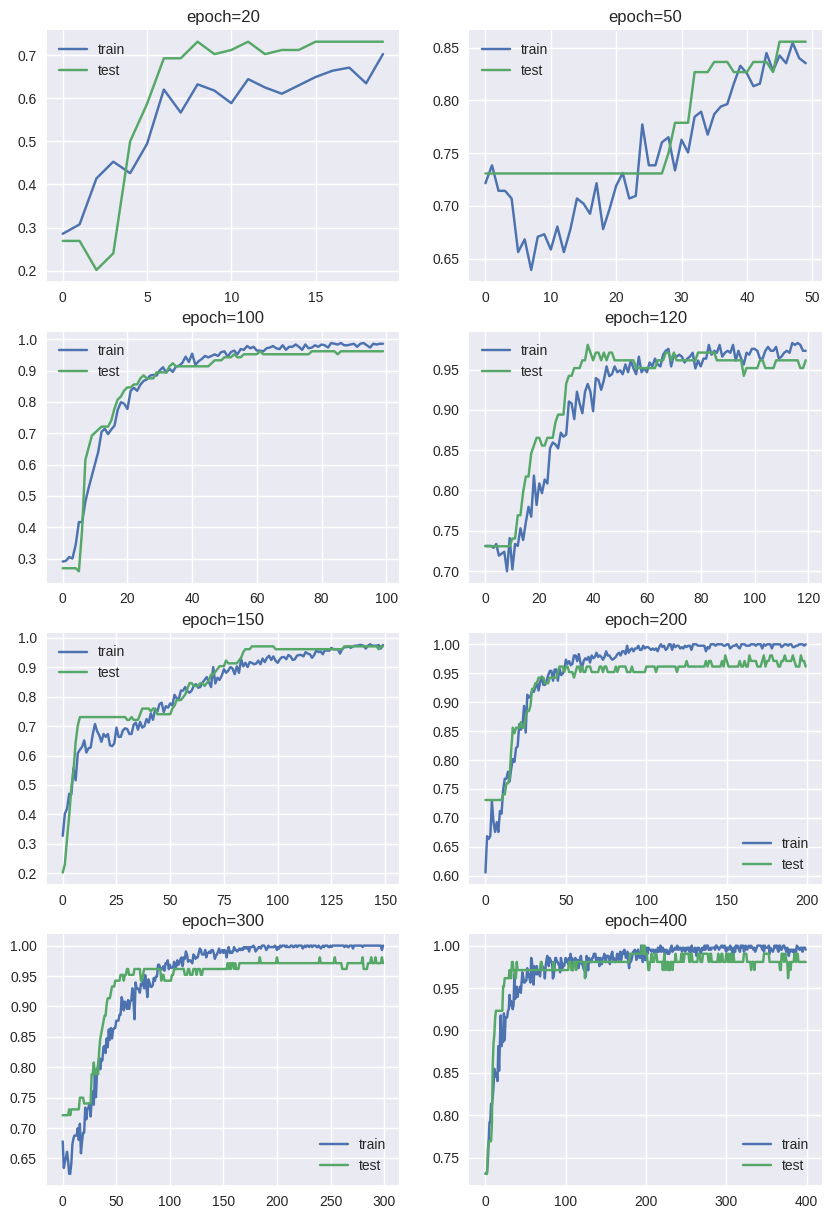

In [ ]:
#experiment ANN modelling with different hyperparameter values

# Define a function to fit the model and plot learning curves
def fit_model(trainX, trainy, validX, validy, n_epoch):
    # Define model
    model = Sequential()
    model.add(Dense(6, input_dim=13, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))

    # Compile model
    model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')

    # Fit model
    history = model.fit(trainX, trainy, validation_data=(validX, validy), epochs=n_epoch, verbose=0, batch_size=6)

    # Plot learning curves
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('epoch=' + str(n_epoch))
    plt.legend()

# Create learning curves for different batch sizes
epochs = [20, 50, 100, 120, 150, 200, 300, 400]

plt.figure(figsize=(10, 15))
for i in range(len(epochs)):
    # Determine the Plot Number
    plot_no = 420 + (i + 1)
    plt.subplot(plot_no)

    # Fit model and plot learning curves for an epoch value
    fit_model(X_train, y_train, X_test, y_test, epochs[i])

# Show learning curves
plt.show()

Earlystopping

In [ ]:

#Batch Size = 6, Early Stopping (Patience, Model Checkpoint)
# Define a function to initialize the model
def init_model():
    # Define model
    model = Sequential()
    model.add(Dense(6, input_dim=13, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))

    # Compile model
    model.compile(optimizer='adam',
                  metrics=['accuracy'],
                  loss='binary_crossentropy')
    return model

# Initialize the model
model = init_model()

# Define early stopping and model checkpoint callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Fit the model with callbacks
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=250, verbose=0, batch_size=6, callbacks=[es, mc])



Epoch 1: val_accuracy improved from -inf to 0.30769, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.30769 to 0.52885, saving model to best_model.h5

Epoch 3: val_accuracy improved from 0.52885 to 0.55769, saving model to best_model.h5

Epoch 4: val_accuracy improved from 0.55769 to 0.60577, saving model to best_model.h5

Epoch 5: val_accuracy improved from 0.60577 to 0.64423, saving model to best_model.h5

Epoch 6: val_accuracy did not improve from 0.64423

Epoch 7: val_accuracy improved from 0.64423 to 0.66346, saving model to best_model.h5

Epoch 8: val_accuracy improved from 0.66346 to 0.67308, saving model to best_model.h5

Epoch 9: val_accuracy improved from 0.67308 to 0.73077, saving model to best_model.h5

Epoch 10: val_accuracy did not improve from 0.73077

Epoch 11: val_accuracy did not improve from 0.73077

Epoch 12: val_accuracy did not improve from 0.73077

Epoch 13: val_accuracy did not improve from 0.73077

Epoch 14: val_accuracy did not improve from 0.73077

Epoch 15: val_accuracy did not improve from 0.73077

Epoch 16: val_accura

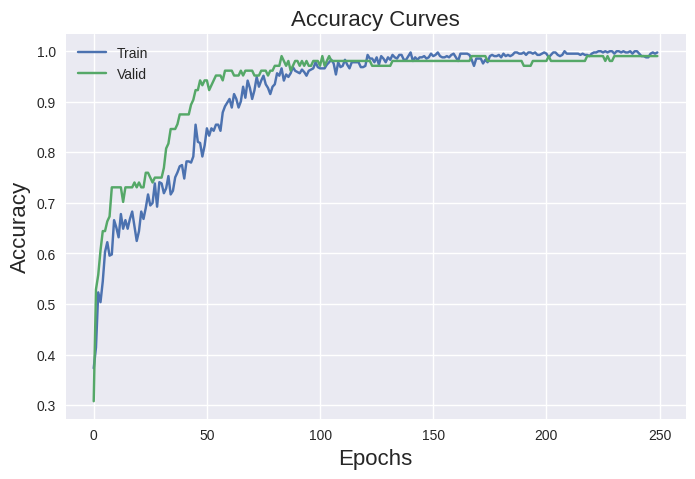

In [ ]:
plt.figure(figsize=[8,5])
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Valid')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)
plt.show()

In [ ]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, valid_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Valid: %.3f' % (train_acc, valid_acc))

Train: 1.000, Valid: 0.990


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

In [ ]:
#The model consists of four LSTM layers and a dense output layer.
model_2 = Sequential()

model_2.add(LSTM(units=100, return_sequences = True, input_shape =(X_train.shape[1],1)))
model_2.add(Dropout(0.2))

model_2.add(LSTM(units=100, return_sequences = True))
model_2.add(Dropout(0.2))

model_2.add(LSTM(units=100, return_sequences = True))
model_2.add(Dropout(0.2))

model_2.add(LSTM(units=100, return_sequences = False))
model_2.add(Dropout(0.2))

model_2.add(Dense(units =1))

model_2.compile(optimizer = 'adam', metrics=['accuracy'], loss ='binary_crossentropy')
model_2.summary()

NameError: ignored

In [ ]:
history = model_2.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 100)

Epoch 1/100
42/42 [==============================] - 12s 103ms/step - loss: 4.1458 - accuracy: 0.7312 - val_loss: 4.1529 - val_accuracy: 0.7308
Epoch 2/100
42/42 [==============================] - 2s 58ms/step - loss: 3.8266 - accuracy: 0.7240 - val_loss: 3.6603 - val_accuracy: 0.6058
Epoch 3/100
42/42 [==============================] - 2s 40ms/step - loss: 2.6851 - accuracy: 0.6634 - val_loss: 2.1707 - val_accuracy: 0.7308
Epoch 4/100
42/42 [==============================] - 2s 39ms/step - loss: 1.5278 - accuracy: 0.7312 - val_loss: 1.5211 - val_accuracy: 0.7308
Epoch 5/100
42/42 [==============================] - 2s 39ms/step - loss: 1.1785 - accuracy: 0.7312 - val_loss: 0.6265 - val_accuracy: 0.7308
Epoch 6/100
42/42 [==============================] - 2s 41ms/step - loss: 0.5999 - accuracy: 0.7215 - val_loss: 0.5678 - val_accuracy: 0.7308
Epoch 7/100
42/42 [==============================] - 2s 40ms/step - loss: 0.5889 - accuracy: 0.7264 - val_loss: 0.5779 - val_accuracy: 0.7308
Epoc

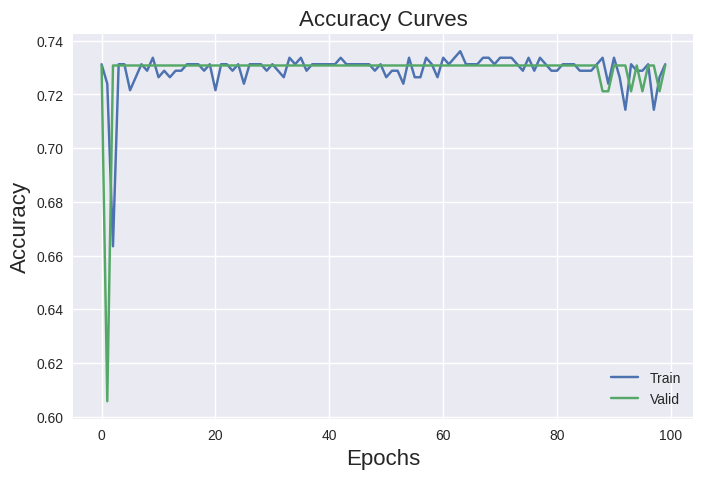

In [ ]:
plt.figure(figsize=[8,5])
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Valid')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)
plt.show()

In [ ]:
_, train_acc = model_2.evaluate(X_train, y_train, verbose=0)
_, valid_acc = model_2.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Valid: %.3f' % (train_acc, valid_acc))

Train: 0.734, Valid: 0.731
